Nous allons entraîner et utiliser des modèles de langage pour la traduction automatique.

Nous disposons d'une *séquence* d'entrée (la phrase source) que nous souhaitons transformer en une séquende de sortie (la phrase traduite). Le type d'architecture neuronale que nous allons utiliser pour cela s'appelle donc en toute logique *seq2seq* (séquence vers séquence).

## Préparatifs

**Important :** Il est donc fortement conseillé d'exécuter ce notebook sur Google Colab.

(`nmt_dataset.py`, `nnet_models.py`, `prepare.py`)

Il faut redémarrer le noyau Python après installation.

In [ ]:
# Installation des librairies
!pip install torch jupyter subword-nmt sacremoses googletrans==3.1.0a0 pandas sacrebleu matplotlib


In [ ]:
# Chargement des bibliothèques

# Fonctions auxilliaires prédéfinies
import nmt_dataset
import nnet_models

# PyTorch, une bibliothèque d'apprentissage machine similaire à Tensorflow (que Keras utilise)
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Bibliothèques Python standard
import os
import sys
import time
import copy
from functools import partial

# Chargement et traitement des données et des matrices
import numpy as np
import pandas as pd

# Visualisation sous forme de graphiques
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Barre de chargement pour les opérations lentes
from tqdm.notebook import tqdm

# Outil aidant à la construction du tokenizer
from subword_nmt.apply_bpe import BPE

# Instance de Google Traduction, qui nous servira de référence
from googletrans import Translator
translator = Translator()

%matplotlib inline

# Préparation du corpus de traduction

Le modèle que nous allons développer dans ce TP est un modèle de traduction de l'anglais vers le français. Afin de l'élaborer, nous utiliserons les données du projet [Tatoeba](https://tatoeba.org/fr), qui sont distribuées sous licence libre Creative Commons et hebergées par [Anki](www.manythings.org/anki).  

Pour pouvoir entraîner un modèle de traduction, il nous faut disposer d'un corpus *parallèle*, c'est-à-dire constitué d'une collection de phrases sources (`source_lang`) et de traductions de référence (`target_lang`). Par parallèle, on entend que ces deux collections doivent être alignées phrase par phrase. Dans notre cas, elles seront stockées dans deux fichiers, de telle sorte que chaque ligne du fichier de référence soit la traduction de la même ligne dans le fichier source.

Vous avez vu en cours que les corpus textuels doivent en général être pré-traités, ce que nous avons ignoré pour des raisons de simplicité au cours du TP précédent. Une des étapes les plus importantes du pré-traitement est la tokenization, qui consiste à découper chaque document (phrase) en plus petit morceaux appelés *tokens*. L'outil effectuant cette découpe s'appelle un *tokenizer*, et il en existe divers types, qui découpent par exemple le texte initial en mots, en sous-mots ou en caractères individuels. Ici, nous utiliserons un tokenizer en sous-mots de type *Byte Pair Encoding* (BPE), en utilisant la bibliothèque [`subword_nmt`](https://github.com/rsennrich/subword-nmt). Cette bibliothèque a la particularité qu'elle peut s'utiliser même hors de Python, directement dans le terminal. C'est ce que nous allons faire.

Comme le reste du modèle, le tokenizer doit être entraîné afin de déterminer quelles découpes ont du sens, en fonction des sous-mots qui sont les plus fréquents. Ici, le modèle que nous entraînons est un modèle BPE français-anglais, capable de faire la tokenization de phrases anglaises et françaises.

### Apprentissage du tokenizer
La cellule effectue les opérations suivantes :
- Passage en mode shell (exécution des commandes dans le terminal)
- Téléchargement et extraction des données si elles n'existent pas
- Séparation des données en jeux d'entraînement, de validation et de test (fonction auxilliaire contenue dans `prepare.py`)
- Entraînement du tokenizer

In [ ]:
%%shell
mkdir -p data

if [ ! -f data/train.en-fr.fr ]; then
    pushd data
    wget -nc https://www.manythings.org/anki/fra-eng.zip
    unzip -o fra-eng.zip
    popd
    python3 prepare.py data/fra.txt
fi

if [ ! -f data/bpecodes.en-fr ]; then
    cat data/train.en-fr.{en,fr} | subword-nmt learn-bpe -o data/bpecodes.en-fr -s 8000 -v
fi

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
pair 3001: wor ds</w> -> words</w> (frequency 223)
pair 3002: thir ty</w> -> thirty</w> (frequency 223)
pair 3003: tal ked</w> -> talked</w> (frequency 223)
pair 3004: t ée</w> -> tée</w> (frequency 223)
pair 3005: rivi ère</w> -> rivière</w> (frequency 223)
pair 3006: qu a -> qua (frequency 223)
pair 3007: pl ain -> plain (frequency 223)
pair 3008: par c</w> -> parc</w> (frequency 223)
pair 3009: celu i</w> -> celui</w> (frequency 223)
pair 3010: av is</w> -> avis</w> (frequency 223)
pair 3011: ab solu -> absolu (frequency 223)
pair 3012: veu lent</w> -> veulent</w> (frequency 222)
pair 3013: t ain</w> -> tain</w> (frequency 222)
pair 3014: pru d -> prud (frequency 222)
pair 3015: or d</w> -> ord</w> (frequency 222)
pair 3016: onn aire</w> -> onnaire</w> (frequency 222)
pair 3017: journ al</w> -> journal</w> (frequency 222)
pair 3018: compl et -> complet (frequency 222)
pair 3019: anni vers -> annivers (freq

In [ ]:
# Définition de quelques variables utiles, et lecture du corpus parallèle
data_dir = 'data/'
source_lang = 'en'
target_lang = 'fr'
model_dir = 'models/{}-{}'.format(source_lang, target_lang)

data_df = pd.read_csv(data_dir + 'fra.txt',
                      encoding='UTF-8', sep='\t', header=None,
                      names=['eng', 'fra'], index_col=False)
data_df

<ipython-input-5-d46da39b69f0>:7: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  data_df = pd.read_csv(data_dir + 'fra.txt',


,eng,fra
0,Go.,Va !
1,Go.,Marche.
2,Go.,En route !
3,Go.,Bouge !
4,Hi.,Salut !
...,...,...
232731,Death is something that we're often discourage...,La mort est une chose qu'on nous décourage sou...
232732,Since there are usually multiple websites on a...,Puisqu'il y a de multiples sites web sur chaqu...
232733,If someone who doesn't know your background sa...,Si quelqu'un qui ne connaît pas vos antécédent...
232734,It may be impossible to get a completely error...,Il est peut-être impossible d'obtenir un Corpu...



Le corpus contient 232736 lignes et 2 colonnes en anglais et français. Il s'agit d'un corpus parallèle.

Le tokenizer BPE découpe les mots en sous-unités fréquentes, et après entraînement, il fusionne les paires de caractères les plus fréquentes pour notre modèle (fr-ang)













## Chargement et prétraitement des données

Le chargement et prétraitement des données consiste ici en 5 étapes :
1. Charger le tokenizer BPE en mémoire,
2. Charger les jeux d'entraînement, de validation et de test du corpus parallèle français-anglais. La fonction `load_data` va charger le corpus, puis le tokenizer en utilisant le fonction `preprocess`.
3. Créer ou charger le dictionnaire associant les tokens à leur identifiants uniques (IDs) (fonction `nmt_dataset.load_or_create_dictionary`)
4. Numériser les données en transformant chaque séquence source et cible en une séquences d'identifiants, et en les triant par taille (fonction `nmt_dataset.binarize`)
5. Créer les lots d'entraînement (batches) (classe `nmt_dataset.BatchIterator`) en groupant ensemble les séquences d'une taille similaire. Les séquences sont ensuite complétées de zéros (*padding*) afin qu'elles aient toutes la même longueur. Toutes les séquences sont contenues dans des matrices numpy, qui seront utilisées pour entrainer les modèles.

In [ ]:
# Reproducibilité des résultats
def reset_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)

#### 1. Chargement du tokenizer (bilingue français-anglais)

In [ ]:
bpe_path = os.path.join(data_dir, 'bpecodes.en-fr')

with open(bpe_path) as bpe_codes:
    bpe_model = BPE(bpe_codes)

# Fonction qui tokenize un document
def preprocess(line, is_source=True, source_lang=None, target_lang=None):
    return bpe_model.segment(line.lower())

# Fonction qui détokenize un document
def postprocess(line):
    return line.replace('@@ ', '')

def load_data(source_lang, target_lang, split='train', max_size=None):
    path = os.path.join(data_dir, '{}.{}-{}'.format(split, *sorted([source_lang, target_lang])))
    return nmt_dataset.load_dataset(path, source_lang, target_lang, preprocess=preprocess, max_size=max_size)

#### 2. Chargement et prétraitement du corpus parallèle
Comme évoqué plus haut, les données de notre corpus sont parallèles.
Le code ci-dessous charge les données dans les partitions `train`, `dev` et `test` et affiche un exemple de données source et cible avec le resultat de la tokenization.  

In [ ]:
train_data = load_data(source_lang, target_lang, 'train', max_size=None)
valid_data = load_data(source_lang, target_lang, 'valid')
test_data = load_data(source_lang, target_lang, 'test')
train_data.head()

,source_data,target_data,source_tokenized,target_tokenized
0,can we not talk about that now ?,pouvons-nous ne pas parler de cela maintenant ?,"[can, we, not, talk, about, that, now, ?]","[pouvons-nous, ne, pas, parler, de, cela, main..."
1,i remember when i was about your age .,je me souviens de lorsque j' avais à peu près ...,"[i, remember, when, i, was, about, your, age, .]","[je, me, souviens, de, lorsque, j', avais, à, ..."
2,he gave up his dream of becoming a pilot .,il abandonna son rêve de devenir pilote .,"[he, gave, up, his, dream, of, be@@, coming, a...","[il, abandonn@@, a, son, rêve, de, devenir, pi..."
3,tell me if you 're in good shape .,dis-moi si tu es en forme .,"[tell, me, if, you, 're, in, good, shape, .]","[dis-moi, si, tu, es, en, forme, .]"
4,french is one of the languages i 've always wa...,le français est une des langues que j' ai touj...,"[french, is, one, of, the, languages, i, 've, ...","[le, français, est, une, des, langues, que, j'..."


Le symbole '@@' indique que le mot suivant est une continuation de le mot précédent. Il signale qu'il s'agit d'une sous-unité d'un mot qui a été segmenté par le tokenizer (pour reconstruire correctement le mot lors de la détokenization.)

#### 3. Création/Chargement du dictionnaire

La prochaine étape est de determiner le vocabulaire utilisé dans les données. Ce vocabulaire est stocké dans deux listes (une pour chaque langue) appelées dictionnaires. Les dictionnaires sont triés par ordre de fréquence des mots.

In [ ]:
source_dict_path = os.path.join(model_dir, 'dict.{}.txt'.format(source_lang))
target_dict_path = os.path.join(model_dir, 'dict.{}.txt'.format(target_lang))

source_dict = nmt_dataset.load_or_create_dictionary(
    source_dict_path,
    train_data['source_tokenized'],
    minimum_count=10,
    reset=False
)

target_dict = nmt_dataset.load_or_create_dictionary(
    target_dict_path,
    train_data['target_tokenized'],
    minimum_count=10,
    reset=False
)
print(source_dict.words[:1000])

print(target_dict.words[:1000])
print('Source vocab size:', len(source_dict))
print('Target vocab size:', len(target_dict))

['<sos>', '<eos>', '<unk>', '<pad>', '.', 'i', 'you', 'a', 'to', '?', 'the', 'that', "'t", 'is', 'we', 'tom', 'was', 'in', 'he', "'s", 'this', 'it', 'do', "'re", 'of', 'your', 'have', 'don', 'are', ',', 'my', 'me', 'what', "'m", 'know', 'how', 'did', 'all', 'here', 'not', 'be', 'they', 'can', 'she', 'want', 'for', "'ll", 'with', 'need', 'on', 'like', 'didn', 'time', 'his', 'get', 'go', 'there', 'up', "'ve", 'let', 'were', 'an', 'very', 'where', 'think', 'going', 'house', 'him', 'at', 'good', 'please', 'just', 'will', 'about', 'when', '"', 'isn', 'no', 'and', 'out', 'help', 'has', 'if', 'could', 'back', 'take', 'as', 'got', 'see', 'should', 'eat', 'who', 'why', '!', 'something', 'tell', 'must', 'so', 'had', 'work', 'from', 'one', 'right', 'again', 'but', 'really', 'some', 'by', 'more', 'our', 'her', 'things', 'always', 'give', 'ask', 'mary', 'ing', "'d", 'now', 'talk', 'yourself', 'stay', 'anything', 'been', 'today', 'come', 'last', 'better', 'make', 'us', 'day', 'told', 'everyone', 'do

Un vocabulaire basé sur des données d'apprentissage est mieux adapté au corpus et le contexte qu'un vocabulaire standard.
Un vocabulaire standard pourrait ne pas contenir des termes ou des expressions spécifiques présents dans les données d'entraînement, ce qui pourrait nuire à la qualité des traductions.

3. sos : Start of sentence (début de phrase)
eos : End of sentence (fin de phrase)
unk : Unknown (mot inconnu)
pad : Padding (remplissage)

4. Taille du vocabulaire source (anglais): 4193
Taille du vocabulaire cible (français): 5218
(La différence s'explique par la diversité lexicale et les structures grammaticales distinctes entre les deux langues.)

Les deux vocabulaires peuvent partager des sous-mots en raison de l'utilisation de BPE, qui segmente les mots en unités plus petites.




#### 4. Utilisation du dictionnaire pour associer les tokens à leurs indices.


In [ ]:
nmt_dataset.binarize(train_data, source_dict, target_dict, sort=True)
nmt_dataset.binarize(valid_data, source_dict, target_dict, sort=False)
nmt_dataset.binarize(test_data, source_dict, target_dict, sort=False)
train_data.head()


,source_data,target_data,source_tokenized,target_tokenized,source_bin,source_len,target_bin,target_len
11975,welcome .,bienvenue !,"[welcome, .]","[bienvenue, !]","[1137, 4, 1]",3,"[2585, 42, 1]",3
15910,run .,file !,"[run, .]","[file, !]","[517, 4, 1]",3,"[2481, 42, 1]",3
17103,go .,va !,"[go, .]","[va, !]","[55, 4, 1]",3,"[91, 42, 1]",3
21622,wonderful !,super !,"[wonderful, !]","[super, !]","[1435, 93, 1]",3,"[2924, 42, 1]",3
26245,thanks .,merci .,"[thanks, .]","[merci, .]","[881, 4, 1]",3,"[503, 4, 1]",3


#### Statistiques du corpus d'entrainement

In [ ]:
print('train_size={}, valid_size={}, test_size={}, min_len={}, max_len={}'.format(
    len(train_data),
    len(valid_data),
    len(test_data),
    train_data['source_len'].min(),
    train_data['source_len'].max(),
))

print('Distribution des longueurs de documents source (jeu d\'entraînement) :')
train_data['source_len'].describe()

train_size=228736, valid_size=2000, test_size=2000, min_len=3, max_len=85
Distribution des longueurs de documents source (jeu d'entraînement) :


,source_len
count,228736.000000
mean,9.050097
std,3.019754
min,3.000000
25%,7.000000
50%,9.000000
75%,10.000000
max,85.000000


Entraînement : 228736 paires
Validation : 2000 paires
Test : 2000 paires

La longueur en tokens du document source le plus court est de 3 tokens.
La longueur en tokens du document source le plus long est de 85 tokens.
La taille médiane en tokens des documents source est de 9 tokens.







#### 5. Construction des lots (batches)
Nous regroupons ici les différents documents en lots (*batches*), ce qui permettra d'entraîner notre modèle sur plusieurs documents en parallèle et donc plus rapidement.
Les lots sont automatiquement mélangés (shuffled) avant chaque itération d'entraînement.

In [ ]:
max_len = 30       # Maximum 30 tokens par document (les documents plus long seront tronqués)
batch_size = 512   # Maximum 512 tokens par lot

reset_seed()

train_iterator = nmt_dataset.BatchIterator(train_data, source_lang, target_lang, batch_size=batch_size, max_len=max_len, shuffle=True)
valid_iterator = nmt_dataset.BatchIterator(valid_data, source_lang, target_lang, batch_size=batch_size, max_len=max_len, shuffle=False)
test_iterator = nmt_dataset.BatchIterator(test_data, source_lang, target_lang, batch_size=batch_size, max_len=max_len, shuffle=False)

# Affiche le premier lot du jeu d'entraînement
print(next(iter(train_iterator)))

{'source': tensor([[  82,   14,  425,   32,   14,   60,  211,   29,   21,  530,   12,   40,
          362,  576,  987,  521,   29,  142,   21,    9,    1],
        [   5,   71,   27,   12,  202,   32, 1177,  855,   10, 1141,  439,   24,
          143,   91, 2205, 1666,  397, 2222,  317,    4,    1],
        [   5,   33,   39,   61, 3398,   29,   97,   30,  409,    8,   25,  333,
           13,   71,   61,  416, 1278, 1306,  452,    4,    1],
        [   5,   33,   39,   61, 3398,   29,   97,   30,  409,    8,   25,  333,
           13,   71,   61,  416, 1278, 1306,  452,    4,    1],
        [  15,   36,  190, 1942,   53, 2005,    8,  981,   10,  286,   11,   60,
          704, 1791,   17,   10, 1289,  952,  742,    4,    1],
        [  45,    7,  314,   91,   13,   17,   69, 2704,  655, 2219,   29, 3675,
         2301, 2208, 1890,   13,    7, 3910,  521,    4,    1],
        [  75,   35,  139,  133,   21,   85,    8,   54,    8, 1581, 3984,    7,
           49, 1369,    9,   75,   18,

Le modèle séquence vers séquence (seq2seq)
=================

Une approche naïve pour traduire les phrases consisterait à traduire chaque mot séparément, puis à recoller les traductions des mots individuels bout à bout. Cependant, cela ne marche pas. Considérons la phrase "I am not the black cat" → "Je ne suis pas le chat noir". La plupart des mots de la phrase d'entrée ont une traduction directe dans la phrase de sortie, mais sont dans un ordre légèrement différents, par exemple "chat noir" et "black cat". De plus, du fait de la construction "ne/pas", il y a un mot de moins dans la phrase d'entrée.

Pour remédier à ce problème, un modèle seq2seq se compose généralement de deux parties, appelées *encodeur* et *décodeur*. L'encodeur lit une séquence d'entrée et produit un vecteur unique (encodage), qui correspond à une abstraction de la phrase d'entrée. Le décodeur lit ce vecteur pour produire une séquence de sortie, qui peut donc être de longueur et de forme différente de celle d'entrée.
Le modèle seq2seq est indépendant de la longueur et de l'ordre des séquences, ce qui le rend idéal pour la traduction entre deux langues.

![seq2seq](https://pytorch.org/tutorials/_images/seq2seq.png)

*Source de l'image: pytorch.org*

L'encodeur
-----------

L'encodeur est la partie qui prend une phrase et nous en donne une représentation (vecteur). Dans la version la plus simple, l'encodeur d'un réseau seq2seq peut être un RNN, qui produit une valeur pour chaque mot de la phrase d'entrée. Plus précisément, pour chaque mot d'entrée, l'encodeur produit un vecteur et un état caché, et utilise l'état caché pour prédire le mot d'entrée suivant.

Le décodeur
-----------

Le décodeur est un autre réseau de neurones, qui prend le(s) vecteur(s) de sortie de l'encodeur et produit une séquence de mots (traduction) à partir de celle-ci.

Dans le décodeur seq2seq le plus simple, nous utilisons uniquement la dernière sortie de l'encodeur. Cette dernière sortie est parfois appelée le *vecteur de contexte*, car elle encode le contexte de la séquence entière. Ce vecteur de contexte peut être utilisé comme état caché initial pour un décodeur, qui peut être par exemple de type RNN.

À chaque étape du décodage, le décodeur reçoit un token d'entrée et un état caché. Le token d'entrée initial est le token de début de chaîne et le premier état caché est le vecteur de contexte (le dernier état caché de l'encodeur).

Le décodeur
--------------------

Le décodeur est un autre réseau RNN qui prend le ou les vecteurs de sortie de l'encodeur et produit une séquence de mots pour générer la traduction.

Dans le décodeur seq2seq le plus simple, nous utilisons uniquement la dernière sortie de l'encodeur. Cette dernière sortie est parfois appelée le vecteur de contexte car elle code le contexte de la séquence entière. Ce vecteur de contexte peut être utilisé comme état caché initial pour un décodeur RNN.

À chaque étape du décodage, le décodeur reçoit un token d'entrée et un état caché. Le token d'entrée initial est le token de début de chaîne et le premier état caché est le vecteur de contexte (le dernier état caché de l'encodeur).

![Illustration encodeur-decodeur (l'image seq2seq.png)](seq2seq.png)

## Encodeur et décodeur RNN

In [ ]:
rnn_encoder = nnet_models.RNN_Encoder(
    input_size=len(source_dict),
    hidden_size=512,
    num_layers=1,
    dropout=0.2
)

print(rnn_encoder)

RNN_Encoder(
  (embedding): Embedding(4193, 512, padding_idx=3)
  (gru): GRU(512, 512, batch_first=True)
)


In [ ]:
rnn_decoder = nnet_models.RNN_Decoder(
    output_size=len(target_dict),
    hidden_size=512,
    num_layers=1,
    dropout=0.2
)

print(rnn_decoder)

RNN_Decoder(
  (embedding): Embedding(5218, 512, padding_idx=3)
  (dropout): Dropout(p=0.2, inplace=False)
  (gru): GRU(512, 512, batch_first=True)
  (out): Linear(in_features=512, out_features=5218, bias=True)
  (softmax): LogSoftmax(dim=2)
)


In [ ]:
rnn_model = nnet_models.EncoderDecoder(
    rnn_encoder,
    rnn_decoder,
    lr=0.001,
    use_cuda=True,
    target_dict=target_dict
)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



1. `input_size=len(source_dict)` : Le nombre d'entrées du modèle, correspondant à la taille du dictionnaire source utilisé pour encoder les tokens de la langue source.


2. `output_size=len(target_dict)` : Le nombre de sorties du modèle, correspondant à la taille du dictionnaire cible, qui encode les tokens de la langue cible dans un modèle de traduction.


3. `hidden_size=512` : La taille des vecteurs d'état caché dans le modèle.


4. `num_layers=1` : 1 couche récurrente dans le modèle (monocouche).


5. `dropout=0.2`: Le taux de dropout, probabilité de 20% (0.2) pour désactiver aléatoirement des neurones pendant l'entraînement afin d'éviter le surapprentissage (overfitting).


6. `lr=0.001` : lr=0.001 : Taux d'apprentissage fixé à 0.001 pour l'optimisation. (un paramètre qui contrôle la vitesse à laquelle le modèle ajuste ses poids pendant l'entraînement)

# Apprentissage du modèle de traduction

## Programmation de l'apprentissage

Comme dans les TP précédents, l'apprentissage s'effectue durant un certain nombre d'itérations. Pour verifier si l'apprentissage évolue positivement, nous utilisons deux mesures pour évaluer le modèle à chaque itération :
- La fonction de coût du modèle
- La mesure BLEU, qui est une métrique couramment utilisée en traduction. Cette métrique compare la sortie du modèle à une traduction de référence, et lui attribue un score.

Le code ci-dessous sert à effectuer l'apprentissage du modèle :

In [ ]:
def save_model(model, checkpoint_path):
    # Fonction servant à enregistrer le réseau de neurones
    dirname = os.path.dirname(checkpoint_path)
    if dirname:
        os.makedirs(dirname, exist_ok=True)
    torch.save(model, checkpoint_path)

def train_model(
        train_iterator,
        valid_iterators,
        model,
        checkpoint_path,
        epochs=10,
        validation_frequency=1
    ):

    reset_seed()  # Reproducibilité
    epochsX = list(range(1, epochs+1))
    epoch_lossY = []
    epoch_loss_validation = []

    best_bleu = -1
    for epoch in range(1, epochs + 1):

        start = time.time()
        running_loss = 0
        running_loss_dev = 0

        print('Itération : [{}/{}]'.format(epoch, epochs))

        # Enumère tous les lots d'entraînement
        for i, batch in tqdm(enumerate(train_iterator), total=len(train_iterator)):
            t = time.time()
            running_loss += model.train_step(batch)

        # Calcule la fonction de coût moyenne sur le jeu d'entraînement pour cette itération
        epoch_loss = running_loss / len(train_iterator)
        epoch_lossY.append(epoch_loss)

        print("Coût (train)={:.3f}, durée={:.2f}".format(epoch_loss, time.time() - start))

        # Enumère tous les lots de validation
        for i, batch in tqdm(enumerate(valid_iterators[0]), total=len(valid_iterators[0])):
            t_dev = time.time()
            running_loss_dev += model.dev_step(batch)

        # Calcule la fonction de coût moyenne sur le jeu de validation pour cette itération
        epoch_loss_dev = running_loss_dev / len(valid_iterators[0])
        epoch_loss_validation.append(epoch_loss_dev)

        print("Coût (valid)={:.3f}, durée={:.2f}".format(epoch_loss_dev, time.time() - start))

        sys.stdout.flush()

        # Évalue et enregistre le modèle
        if epoch % validation_frequency == 0:
            bleu_scores = []

            # Calcule le score BLEU sur tous les lots de validation
            for valid_iterator in valid_iterators:
                src, tgt = valid_iterator.source_lang, valid_iterator.target_lang
                translation_output = model.translate(valid_iterator, postprocess)
                bleu_score = translation_output.score
                output = translation_output.output

                with open(os.path.join(model_dir, 'valid.{}-{}.{}.out'.format(src, tgt, epoch)), 'w') as f:
                    f.writelines(line + '\n' for line in output)

                print('{}-{}: BLEU={}'.format(src, tgt, bleu_score))
                sys.stdout.flush()
                bleu_scores.append(bleu_score)

            # Calcule le score BLEU moyen obtenu
            bleu_score = round(sum(bleu_scores) / len(bleu_scores), 2)
            if len(bleu_scores) > 1:
                print('BLEU={}'.format(bleu_score))

            # Met à jour le taux d'apprentissage du réseau de neurones en fonction du score BLEU.
            # Ici, le taux d'apprentissage est divisé par 10 si le score BLEU n'augmente pas.
            model.scheduler_step(bleu_score)

            # Si le réseau de neurones obtient un score BLEU plus élevé qu'à toutes les itérations précédentes, on l'enregistre
            if bleu_score > best_bleu:
                best_bleu = bleu_score
                save_model(model, checkpoint_path)

        print('=' * 50)

    print("Apprentissage terminé. Meilleure score BLEU : {}".format(best_bleu))

    plt.plot(epochsX, epoch_lossY, '--x', label='Training Loss')
    plt.plot(epochsX, epoch_loss_validation, '--x', label='Validation Loss')
    plt.ylim(0, np.max(epoch_lossY) + 1)
    plt.xticks(range(1,epochs+1))
    plt.xlabel('Epochs')
    plt.ylabel('Epoch Loss')
    plt.legend()

 Le score BLEU est compris entre 0 et 1 (0 à 100 en pourcentage), et il est préférable d'obtenir une valeur élevée, car cela indique une meilleure qualité de traduction.

## Execution de l'apprentissage du modèle de traduction

**Remarque :** l'apprentissage peut durer longtemps (plusieurs minutes). Pour éviter cela, vous pouvez régler `epoch` (le nombre d'itérations) sur une petite valeur, par exemple 2, et relancer cette cellule plusieurs fois pour continuer à entraîner votre modèle (`train_model` ne réinitialise pas le modèle). Si l'apprentissage dure plus de 10 minutes, vérifiez que vous avez bien sélectionne un GPU comme demandé au tout début du TP.

Itération : [1/10]


  0%|          | 0/4587 [00:00<?, ?it/s]

Coût (train)=2.362, durée=49.61


  0%|          | 0/41 [00:00<?, ?it/s]

Coût (valid)=2.092, durée=49.84
en-fr: BLEU=14.12
Itération : [2/10]


  0%|          | 0/4587 [00:00<?, ?it/s]

Coût (train)=1.458, durée=49.76


  0%|          | 0/41 [00:00<?, ?it/s]

Coût (valid)=1.809, durée=49.99
en-fr: BLEU=17.64
Itération : [3/10]


  0%|          | 0/4587 [00:00<?, ?it/s]

Coût (train)=1.240, durée=49.84


  0%|          | 0/41 [00:00<?, ?it/s]

Coût (valid)=1.693, durée=50.07
en-fr: BLEU=19.85
Itération : [4/10]


  0%|          | 0/4587 [00:00<?, ?it/s]

Coût (train)=1.128, durée=49.58


  0%|          | 0/41 [00:00<?, ?it/s]

Coût (valid)=1.656, durée=49.81
en-fr: BLEU=21.08
Itération : [5/10]


  0%|          | 0/4587 [00:00<?, ?it/s]

Coût (train)=1.058, durée=49.69


  0%|          | 0/41 [00:00<?, ?it/s]

Coût (valid)=1.642, durée=49.92
en-fr: BLEU=21.39
Itération : [6/10]


  0%|          | 0/4587 [00:00<?, ?it/s]

Coût (train)=1.010, durée=49.75


  0%|          | 0/41 [00:00<?, ?it/s]

Coût (valid)=1.672, durée=49.98
en-fr: BLEU=21.55
Itération : [7/10]


  0%|          | 0/4587 [00:00<?, ?it/s]

Coût (train)=0.976, durée=49.69


  0%|          | 0/41 [00:00<?, ?it/s]

Coût (valid)=1.631, durée=49.93
en-fr: BLEU=22.23
Itération : [8/10]


  0%|          | 0/4587 [00:00<?, ?it/s]

Coût (train)=0.950, durée=49.53


  0%|          | 0/41 [00:00<?, ?it/s]

Coût (valid)=1.656, durée=49.76
en-fr: BLEU=22.05
Itération : [9/10]


  0%|          | 0/4587 [00:00<?, ?it/s]

Coût (train)=0.737, durée=49.59


  0%|          | 0/41 [00:00<?, ?it/s]

Coût (valid)=1.530, durée=49.82
en-fr: BLEU=25.18
Itération : [10/10]


  0%|          | 0/4587 [00:00<?, ?it/s]

Coût (train)=0.654, durée=49.86


  0%|          | 0/41 [00:00<?, ?it/s]

Coût (valid)=1.538, durée=50.09
en-fr: BLEU=25.23
Apprentissage terminé. Meilleure score BLEU : 25.23


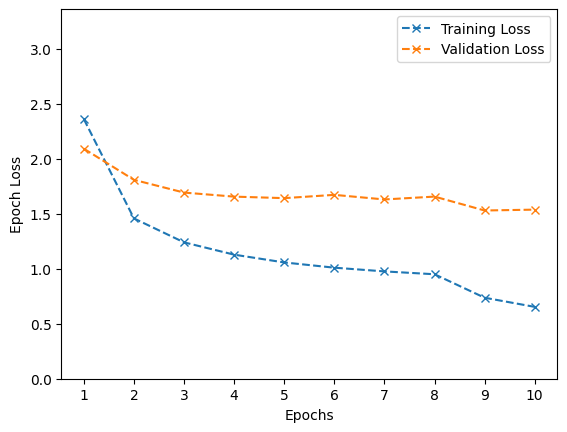

In [ ]:
checkpoint_path = os.path.join(model_dir, 'rnn.pt')

train_model(train_iterator, [valid_iterator], rnn_model,
            epochs=10,
            checkpoint_path=checkpoint_path)

Le coût diminue avec le nombre d'époques, ce qui indique que le modèle s'améliore et s'adapte mieux aux jeux d'entraînement au fil du temps.

Si le coût de validation commence à augmenter alors que le coût d'entraînement continue de diminuer, cela signifie que le modèle commence à sur-apprendre, ce qui indique qu'il mémorise les jeux d'entraînement plutôt que de généraliser correctement à de nouvelles données.


## Evaluation du modèle sur le corpus de test

In [ ]:
print('BLEU:', rnn_model.translate(test_iterator, postprocess).score)

BLEU: 25.83


## Test interactif du modèle

Vous pouvez tester votre modèle de manière interactive soumettant des phrases à traduire de votre choix. Il n'est pas nécessaire de lire ou comprendre le code ci-dessous, il suffit de modifier les phrases de test dans le bloc de code situé après les définitions de fonctions.

In [ ]:
def get_binned_bleu_scores(model, valid_iterator):
    lengths = np.arange(4, 20, 3)
    bleu_scores = np.zeros(len(lengths))

    for i in tqdm(range(1, len(lengths)), total=len(lengths) - 1):
        min_len = lengths[i - 1]
        max_len = lengths[i]

        tmp_data = valid_data[(valid_iterator.data['source_len'] > min_len) & (valid_iterator.data['source_len'] <= max_len)]
        tmp_iterator = nmt_dataset.BatchIterator(tmp_data, source_lang, target_lang, batch_size, max_len=max_len)

        bleu_scores[i] = model.translate(tmp_iterator, postprocess).score

    lengths = lengths[1:]
    bleu_scores = bleu_scores[1:]

    plt.plot(lengths, bleu_scores, 'x-')
    plt.ylim(0, np.max(bleu_scores) + 1)
    plt.xlabel('Source length')
    plt.ylabel('BLEU score')

    return lengths, bleu_scores


def show_attention(input_sentence, output_words, attentions):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions, cmap='bone', aspect='auto')
    fig.colorbar(cax)

    ax.set_xticklabels([''] + input_sentence.split(' ') + [nmt_dataset.EOS_TOKEN], rotation=90)
    ax.set_yticklabels([''] + output_words.split(' ') + [nmt_dataset.EOS_TOKEN])

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def encode_as_batch(sentence, dictionary, source_lang, target_lang):
    sentence = sentence + ' ' + nmt_dataset.EOS_TOKEN
    tensor = dictionary.txt2vec(sentence).unsqueeze(0)

    return {
        'source': tensor,
        'source_len': torch.from_numpy(np.array([tensor.shape[-1]])),
        'source_lang': source_lang,
        'target_lang': target_lang
    }


def get_translation(model, sentence, dictionary, source_lang, target_lang, return_output=False):
    print('Source:', sentence)
    sentence_tok = preprocess(sentence, is_source=True, source_lang=source_lang, target_lang=target_lang)
    print('Tokenized source:', sentence_tok)
    batch = encode_as_batch(sentence_tok, dictionary, source_lang, target_lang)
    prediction, attn_matrix, enc_self_attn = model.eval_step(batch)
    prediction = prediction[0]
    prediction_detok = postprocess(prediction)
    print('Prediction:', prediction)
    print('Detokenized prediction:', prediction_detok)

    print('Google Translate ({}->{}): {}'.format(
        source_lang,
        target_lang,
        translator.translate(sentence, src=source_lang, dest=target_lang).text
    ))
    print('Google Translate on prediction ({}->{}): {}'.format(
        target_lang,
        source_lang,
        translator.translate(prediction_detok, src=target_lang, dest=source_lang).text
    ))

    results = {
        'source': sentence,
        'source_tokens': sentence_tok.split(' ') + ['<eos>'],
        'prediction_detok': prediction_detok,
        'prediction_tokens': prediction.split(' '),
    }

    if attn_matrix is not None:
        attn_matrix = attn_matrix[0].detach().cpu().numpy()
        results['attention_matrix'] = attn_matrix
        show_attention(sentence_tok, prediction, attn_matrix)

    if enc_self_attn is not None:
        results['encoder_self_attention_list'] = enc_self_attn

    if return_output:
        return results

In [ ]:
get_translation(rnn_model, 'hello how are you ?', source_dict, source_lang, target_lang)

Source: hello how are you ?
Tokenized source: hello how are you ?
Prediction: bonjour , comment allez-vous ?
Detokenized prediction: bonjour , comment allez-vous ?
Google Translate (en->fr): bonjour comment allez-vous ?
Google Translate on prediction (fr->en): Good morning, how are you doing ?


In [ ]:
get_translation(rnn_model, 'are hello ? how you', source_dict, source_lang, target_lang)

Source: are hello ? how you
Tokenized source: are hello ? how you
Prediction: est-ce que tu prends tes médicaments ?
Detokenized prediction: est-ce que tu prends tes médicaments ?
Google Translate (en->fr): est-ce que bonjour ? comment tu
Google Translate on prediction (fr->en): are you taking your medication?


In [ ]:
get_translation(rnn_model, 'she \'s five years older than me .', source_dict, source_lang, target_lang)

Source: she 's five years older than me .
Tokenized source: she 's five years older than me .
Prediction: elle a cinq ans de moins que moi .
Detokenized prediction: elle a cinq ans de moins que moi .
Google Translate (en->fr): elle a cinq ans de plus que moi.
Google Translate on prediction (fr->en): She is five years younger than me.


In [ ]:
get_translation(rnn_model, 'i know that the last thing you want to do is help me .', source_dict, source_lang, target_lang)

Source: i know that the last thing you want to do is help me .
Tokenized source: i know that the last thing you want to do is help me .
Prediction: je sais que la dernière chose que vous veuillez faire est de m' aider .
Detokenized prediction: je sais que la dernière chose que vous veuillez faire est de m' aider .
Google Translate (en->fr): je sais que la dernière chose que tu veux faire est de m'aider.
Google Translate on prediction (fr->en): I know the last thing you want to do is help me.


## Tracé du score BLEU en fonction de la longueur de la séquence source

Comme vu en cours, les performances des modèles RNNs chutent lorsque la longueur de l'entrée augmente.
Ceci est dû à trois facteurs principaux :
- Le décodeur RNN se base uniquement sur le dernier état caché de l'encodeur. Cela signifie que nous devons encoder la phrase complète dans un vecteur unique de taille fixe. Plus la phrase est longue, plus cela est difficile.
- Les RNN encodeurs-décodeurs sont difficiles à entraîner (car le signal doit être rétro-propagé à travers toute la séquence d'états).
- L'ensemble d'apprentissage que nous avons utilisé est principalement composé de phrases très courtes (95 % des phrases sources comportent 15 éléments ou moins).

Vous pouvez visualiser ce phénomène sur le graphique suivant :

  0%|          | 0/5 [00:00<?, ?it/s]

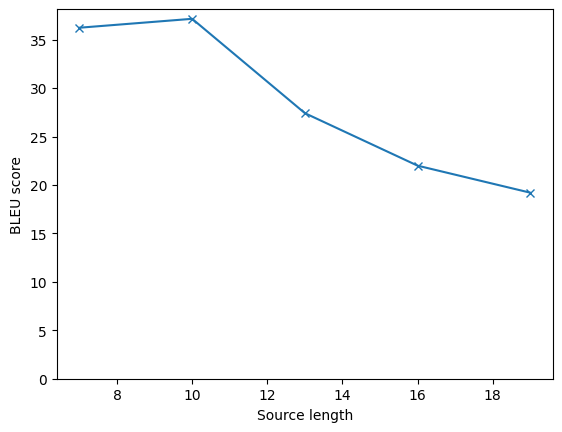

In [ ]:
rnn_lengths, rnn_bleu_scores = get_binned_bleu_scores(rnn_model, valid_iterator)

Le modèle séquence-vers-séquence (seq2seq) avec attention
=================


Le vecteur passé au décodeur doit représenter l'ensemble des informations de l'entrée, ce qui est trop peu, notamment pour les phrases longues. Le mécanisme d'attention est un moyen de recalculer un lien avec les éléments importants de l'entrée à chaque pas de décodage. Ainsi, dans la figure ci-dessous, le terme "Je" dépend plus fortement de termes "I" et "am" que de "a" et "student". Ceci permet au modèle d'être plus flexible et de prendre en compte des dépendances qui peuvent être assez longues.



![seq2seq_avec_attention](https://www.tensorflow.org/images/seq2seq/attention_mechanism.jpg)



*Source de l'image: www.tensorflow.org*




Les architectures avec mécanismes d'attention connaissent beaucoup de succès dans de nombreuses applications comme la traduction, la reconnaissance de la parole, la description d'image, etc. ([cet article de blog constitue une excellente introduction en la matière](https://lilianweng.github.io/lil-log/2018/06/24/attention-attention.html)).

Ici, nous n'avons pas besoin de modifier l'architecture de l'encodeur existant. En revanche, le décodeur fonctionne différemment : en ajoutant un mécanisme d'attention, à chaque étape du décodage, le décodeur reçoit un token d'entrée, l'état caché précédent et un vecteur qui est calculé directement à partir de la séquence d'entrée. Ainsi, à chaque étape de décodage, le décodeur peut donner plus ou moins d'**attention** à des tokens de la source, ce qui permet de prendre en compte des dépendances plus longues que dans la version sans attention.

## Encodeur et décodeur RNN avec attention

In [ ]:
rnn_attn_encoder = nnet_models.RNN_Encoder(
    input_size=len(source_dict),
    hidden_size=512,
    num_layers=1,
    dropout=0.2
)

print(rnn_attn_encoder)

RNN_Encoder(
  (embedding): Embedding(4193, 512, padding_idx=3)
  (gru): GRU(512, 512, batch_first=True)
)


In [ ]:
rnn_attn_decoder = nnet_models.AttentionDecoder(
    output_size=len(target_dict),
    hidden_size=512,
    dropout=0.2
)

print(rnn_attn_decoder)

AttentionDecoder(
  (embedding): Embedding(5218, 512, padding_idx=3)
  (gru): GRUCell(1024, 512)
  (out): Linear(in_features=512, out_features=5218, bias=True)
  (softmax): LogSoftmax(dim=1)
  (attention): AttentionModule(
    (l1): Linear(in_features=512, out_features=512, bias=False)
    (l2): Linear(in_features=1024, out_features=512, bias=False)
  )
)


In [ ]:
rnn_attn_model = nnet_models.EncoderDecoder(
    rnn_attn_encoder,
    rnn_attn_decoder,
    lr=0.001,
    use_cuda=True,
    target_dict=target_dict
)

## Apprentissage du modèle

**Remarque :** l'entrainement est encore plus long que précédemment (3 minutes par itération).

Une ou deux itérations à la fois.

Itération : [1/1]


  0%|          | 0/4587 [00:00<?, ?it/s]

Coût (train)=1.630, durée=212.84


  0%|          | 0/41 [00:00<?, ?it/s]

Coût (valid)=1.713, durée=215.34
en-fr: BLEU=27.46
Apprentissage terminé. Meilleure score BLEU : 27.46


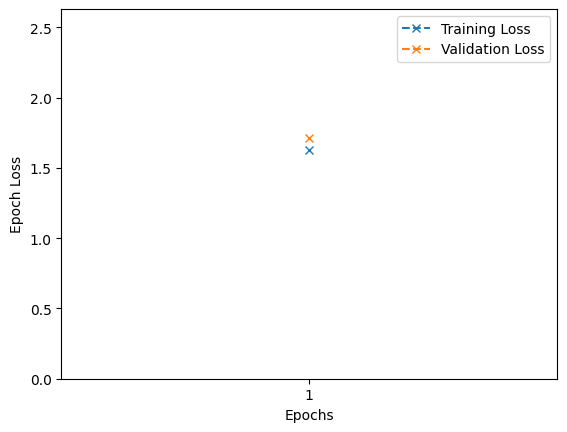

In [ ]:
checkpoint_path = os.path.join(model_dir, 'rnn_attn.pt')

train_model(train_iterator, [valid_iterator], rnn_attn_model,
            epochs=1,
            checkpoint_path=checkpoint_path)

## Évaluation du modèle sur le corpus de test

In [ ]:
print('BLEU:', rnn_attn_model.translate(test_iterator, postprocess).score)

BLEU: 27.82


L'attention améliore la performance car elle permet au modèle de mieux se concentrer sur les parties importantes de la séquence d'entrée.

## Test interactif du modèle et visualisation des matrices d'attention

Vous pouvez tester votre modèle de manière interactive grâce au code ci-dessous, en soumettant des phrases à traduire de votre choix.

Pour chacune des traductions ci-dessous, vérifiez si le mécanisme d'attention permet bien de focaliser la prédiction du prochain mot dans la langue cible sur les mots importants de la séquence d'entrée dans la langue source.

Source: hello how are you ?
Tokenized source: hello how are you ?
Prediction: comment allez-vous ?
Detokenized prediction: comment allez-vous ?
Google Translate (en->fr): bonjour comment allez-vous ?
Google Translate on prediction (fr->en): How are you ?


<ipython-input-19-d1c9640594a9>:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + input_sentence.split(' ') + [nmt_dataset.EOS_TOKEN], rotation=90)
<ipython-input-19-d1c9640594a9>:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output_words.split(' ') + [nmt_dataset.EOS_TOKEN])


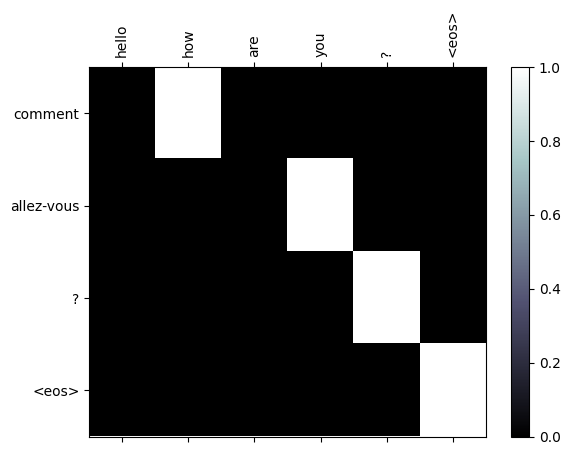

In [ ]:
get_translation(rnn_attn_model, 'hello how are you ?', source_dict, source_lang, target_lang)

Source: are hello ? how you
Tokenized source: are hello ? how you
Prediction: les v@@ êtes sont faites ?
Detokenized prediction: les vêtes sont faites ?
Google Translate (en->fr): est-ce que bonjour ? comment tu
Google Translate on prediction (fr->en): are the clothes done?


<ipython-input-19-d1c9640594a9>:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + input_sentence.split(' ') + [nmt_dataset.EOS_TOKEN], rotation=90)
<ipython-input-19-d1c9640594a9>:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output_words.split(' ') + [nmt_dataset.EOS_TOKEN])


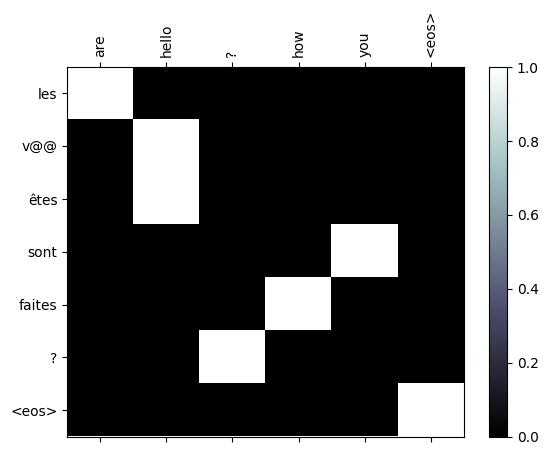

In [ ]:
get_translation(rnn_attn_model, 'are hello ? how you', source_dict, source_lang, target_lang)

Source: she 's five years older than me .
Tokenized source: she 's five years older than me .
Prediction: elle a cinq ans plus que moi .
Detokenized prediction: elle a cinq ans plus que moi .
Google Translate (en->fr): elle a cinq ans de plus que moi.
Google Translate on prediction (fr->en): She is five years older than me.


<ipython-input-19-d1c9640594a9>:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + input_sentence.split(' ') + [nmt_dataset.EOS_TOKEN], rotation=90)
<ipython-input-19-d1c9640594a9>:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output_words.split(' ') + [nmt_dataset.EOS_TOKEN])


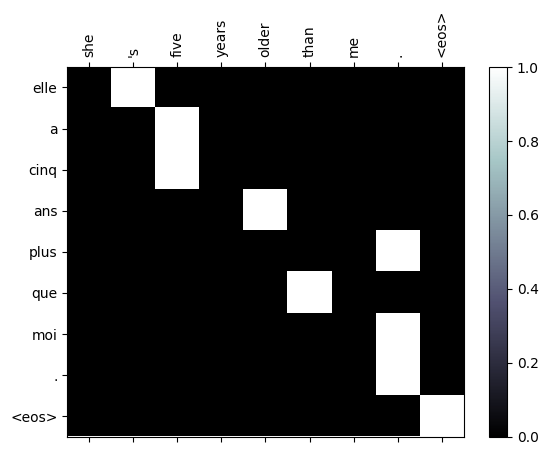

In [ ]:
get_translation(rnn_attn_model, 'she \'s five years older than me .', source_dict, source_lang, target_lang)

Source: i know that the last thing you want to do is help me .
Tokenized source: i know that the last thing you want to do is help me .
Prediction: je sais que je veux que la dernière chose est vouloir vous aider .
Detokenized prediction: je sais que je veux que la dernière chose est vouloir vous aider .
Google Translate (en->fr): je sais que la dernière chose que tu veux faire est de m'aider.
Google Translate on prediction (fr->en): I know the last thing I want is to want to help you.


<ipython-input-19-d1c9640594a9>:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + input_sentence.split(' ') + [nmt_dataset.EOS_TOKEN], rotation=90)
<ipython-input-19-d1c9640594a9>:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output_words.split(' ') + [nmt_dataset.EOS_TOKEN])


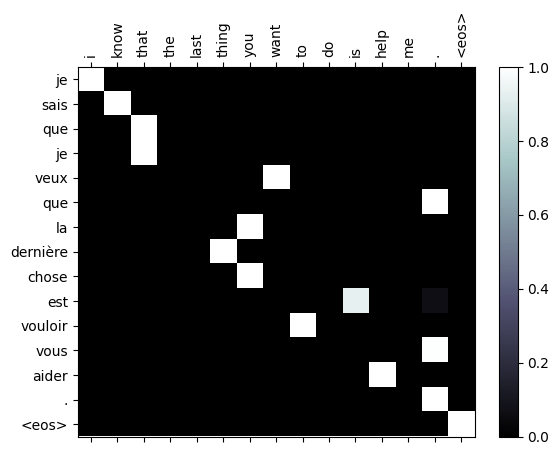

In [ ]:
get_translation(rnn_attn_model, 'i know that the last thing you want to do is help me .', source_dict, source_lang, target_lang)

Les paramètres à changer et dans quelles situations :

Taille des lots (batch_size) : si le modèle semble avoir du mal à converger / si le coût d'entraînement reste élevé./ si le modèle n'apprend pas suffisamment avec une taille de lot plus grande.

Nombre de couches (num_layers) : si le modèle est sous-performant (score BLEU faible) et semble incapable de capturer la complexité des données / si on a suffisamment de données d'entraînement pour éviter le sur-apprentissage.

Nombre de neurones (hidden_size) : si le modèle est lent à entraîner ou si on observe un sur-apprentissage (augmentation du coût de validation par rapport à l'entraînement). Une taille cachée plus petite peut réduire la complexité et aider à généraliser.

Taux de dropout (dropout) : si on remarque un sur-apprentissage, par exemple, lorsque le coût de validation commence à augmenter alors que le coût d'entraînement continue de diminuer.

Taille de la partition de validation : si on a suffisamment de données d'entraînement. Une partition de validation plus grande peut donner une meilleure indication de la performance du modèle.

Epoch,lr...